# Clasificación de datos posterior al agrupamiento

Utilizar un arbol de decisión para determinar las variables más importantes para el clustering y la precisión del modelo

## Carga de datos

In [1]:
import os
import sys
import pandas as pd
import numpy as np
%pip install -q ipywidgets
import ipywidgets as widgets

directorio = '../Results'
# directorio = '/content'

# Leer archivos xlsx dentro de la carpeta Data
files = os.listdir(directorio)
files = [f for f in files if f.endswith('.xlsx')]

# Seleccionar archivo a leer
dropdown = widgets.Dropdown(
  options=[('Seleccionar archivo', None)] + [(f, f) for f in files],
  description='Archivo:',
  disabled=False,
)
nombre_archivo = '';
def on_change(change):
  if change['type'] == 'change' and change['name'] == 'value':
    if change['new'] is not None:
      global nombre_archivo
      global X
      global y
      nombre_archivo = change['new']
      print('Archivo seleccionado:', nombre_archivo)
      ruta = os.path.join(directorio, nombre_archivo)

      # Data split y seleccion de modelos
      dataset = pd.read_excel(ruta)

      X = dataset.drop(columns=['cluster_kmeans', 'cluster_hc', 'Comunidad'])
      y = dataset['cluster_kmeans']
      display(X.head())
      display(y.head())
dropdown.observe(on_change)
display(dropdown)

Note: you may need to restart the kernel to use updated packages.


Dropdown(description='Archivo:', options=(('Seleccionar archivo', None), ('02_clusters_dataset_previo_imputaci…

Archivo seleccionado: 04_clusters.xlsx


,carrera,Espacio_Académico,alumnos,1p_total_actividades_asignadas,1p_total_actividades_evaluativas,1p_porcentaje_evidencias_calificadas,1p_total_actividades_calificadas,1p_total_actividades_entregadas,1p_porcentaje_evidencias_calificadas_tiempo,1p_total_actividades_calificadas_tiempo,...,2p_porcentaje_evidencias_calificadas,2p_total_actividades_calificadas,2p_total_actividades_entregadas,2p_porcentaje_evidencias_calificadas_tiempo,2p_total_actividades_calificadas_tiempo,2p_porcentaje_aprobados,total_actividades_calificadas,trabajos_por_calificar,correos_enviados,correos_recibidos
0,Ingeniería en Computación,Valle de Chalco,25,18,18,1.0,438,438.0,0.998,437.0,...,1.0,452.0,452.0,1.0,452.0,0,890.0,0.0,5.75,2.25
1,Ingeniería en Computación,Valle de Chalco,23,19,19,1.0,402,402.0,1.000,402.0,...,1.0,380.0,380.0,1.0,380.0,0,782.0,0.0,43.00,17.00
2,Ingeniería en Computación (2019),CU Texcoco,43,5,5,1.0,131,131.0,1.000,131.0,...,0.0,0.0,0.0,0.0,0.0,0,131.0,0.0,7.50,2.50
3,Ingeniería en Computación (2019),CU Texcoco,16,6,6,1.0,89,89.0,1.000,89.0,...,1.0,139.0,139.0,1.0,139.0,81,228.0,0.0,21.00,18.00
4,Ingeniería en Computación (2019),CU Texcoco,20,6,6,1.0,102,102.0,1.000,102.0,...,1.0,137.0,137.0,1.0,137.0,50,239.0,0.0,20.75,13.25


0    3
1    3
2    1
3    2
4    2
Name: cluster_kmeans, dtype: int64

## Modelo

cluster_kmeans
2    687
3    196
1    158
Name: count, dtype: int64


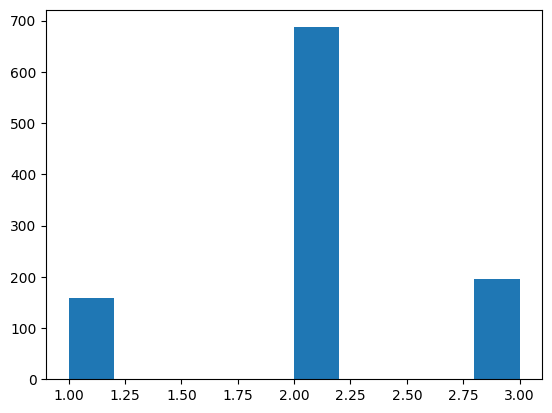

In [2]:
# Ver balance de clases
print(y.value_counts())
# histograma de clases

import matplotlib.pyplot as plt
plt.hist(y)
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Identificar variables categóricas y numéricas
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [4]:
# from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# importar pipeline, column transformer y gridsearch
# from sklearn.pipeline import Pipeline
%pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

# from sklearn.impute import SimpleImputer ya no es necesario por que l
from sklearn.tree import DecisionTreeClassifier


# Crear un pipeline para preprocesar los datos
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

# Combinar los preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(sampling_strategy="auto", random_state=42)),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

# Definir los hiperparámetros a buscar
param_grid = {
    "classifier__max_depth": [1, 2, 3, 4, 5, 7, 9, 10, 12, 14, 15, 20],
    "classifier__min_samples_split": [2, 5, 10],
}

# Definir el esquema de validación cruzada (StratifiedKFold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Realizar la búsqueda en cuadrícula con validación cruzada en el pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring="accuracy")

# Ajustar los datos usando GridSearchCV
grid_search.fit(X_train, y_train)

Note: you may need to restart the kernel to use updated packages.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['alumnos', '1p_total_actividades_asignadas',
       '1p_total_actividades_evaluativas',
       '1p_porcentaje_evidencias_calificadas',
       '1p_total_actividades_cali...
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['carrera', 'Espacio_Académico'], dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [1, 2, 3, 4, 5, 7, 9, 10, 12,
                                                   14, 15, 20],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

Best Hyperparameters:
 {'classifier__max_depth': 9, 'classifier__min_samples_split': 2} 

Accuracy: 0.9169329073482428 

Precision: 0.9177245047341186 

Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.91      0.88        47
           2       0.94      0.94      0.94       207
           3       0.89      0.85      0.87        59

    accuracy                           0.92       313
   macro avg       0.89      0.90      0.90       313
weighted avg       0.92      0.92      0.92       313



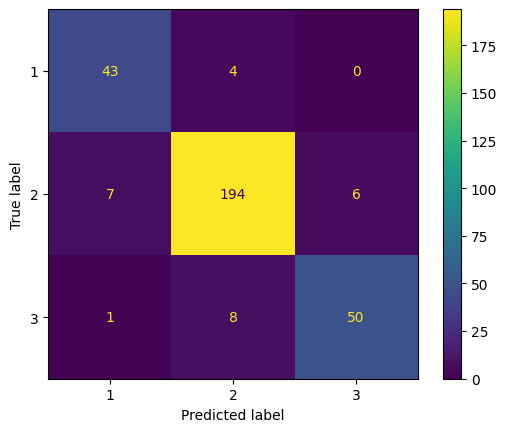

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Ajustar el mejor modelo en los datos de entrenamiento
best_model.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros
best_params = grid_search.best_params_
print("Best Hyperparameters:\n", best_params, '\n')

# Predecir los datos de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, '\n')

# Calcular la precisión
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision, '\n')

# Calcular el reporte de clasificación
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot()


Accuracy: 0.93 (+/- 0.03)


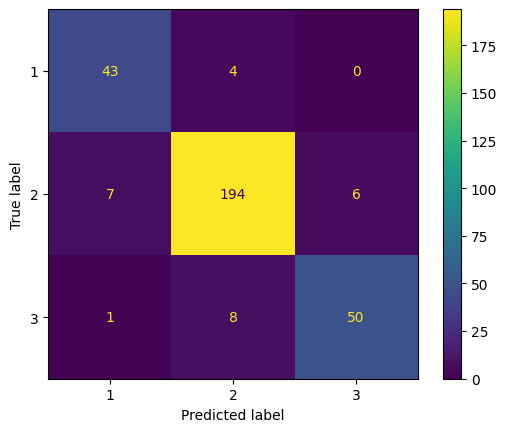

In [6]:
from sklearn.model_selection import cross_val_score
# usando los mejores hiperparámetros
max_depth = best_params['classifier__max_depth']
min_samples_split = best_params['classifier__min_samples_split']
clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

preprocessor = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ])

pipeline = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
  ('classifier', clf)
])

# Calcular la precisión usando validación cruzada
scores = cross_val_score(pipeline, X, y, cv=stratified_kfold, scoring='accuracy')

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# X_train, X_test, y_train, y_test 
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()

plt.show()
    

In [7]:
# Evalauamos en el train set solo para ver que no quedó sobreajustado
train_accuracy = best_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)

# Evaluamos en el test set para ver como generaliza
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 1.0
Test Accuracy: 0.9169329073482428


In [8]:
# Obtenemos las variables más importantes
importances = best_model.named_steps['classifier'].feature_importances_

# Ordenamos las importancias de mayor a menor
indices = np.argsort(importances)[::-1]

# Obtenemos los nombres de las columnas
columnas = X_train.columns
display(columnas)
# Mostramos las 10 variables más importantes
for i in range(5):
    print(f"{columnas[indices[i]]}: {importances[indices[i]]}")

Index(['carrera', 'Espacio_Académico', 'alumnos',
       '1p_total_actividades_asignadas', '1p_total_actividades_evaluativas',
       '1p_porcentaje_evidencias_calificadas',
       '1p_total_actividades_calificadas', '1p_total_actividades_entregadas',
       '1p_porcentaje_evidencias_calificadas_tiempo',
       '1p_total_actividades_calificadas_tiempo', '1p_porcentaje_aprobados',
       '2p_total_actividades_asignadas', '2p_total_actividades_evaluativas',
       '2p_porcentaje_evidencias_calificadas',
       '2p_total_actividades_calificadas', '2p_total_actividades_entregadas',
       '2p_porcentaje_evidencias_calificadas_tiempo',
       '2p_total_actividades_calificadas_tiempo', '2p_porcentaje_aprobados',
       'total_actividades_calificadas', 'trabajos_por_calificar',
       'correos_enviados', 'correos_recibidos'],
      dtype='object')

1p_porcentaje_evidencias_calificadas: 0.42395602083102074
2p_total_actividades_evaluativas: 0.35679021116754744
1p_total_actividades_asignadas: 0.03854277060179205
1p_total_actividades_entregadas: 0.03743810822886909
carrera: 0.03291039581909393
